In [34]:
using SparseArrays, LinearAlgebra, Arpack, PyPlot, LsqFit

# Numerical many-body methods - Problem Set 1 (Exact Diagonalization)
## Noam Ophir

### Ex1. part 0
*As a warm up - consider the Heisenberg chain (i.e. $J_2 = 0$) and write a function that takes a state $|\psi\rangle$ as input, and returns the state $H|\psi\rangle$. Do this without explicitly constructing the Hamiltonian matrix, but rather calculating the coefficients of the output state "on-the-fly". Show that by applying the Hamiltonian multiple times the state rapidly converges to the ground state. (E.g. plot the difference in the energy of the output state and the true ground state energy, and/or the overlap of the state with the ground state, as function of number of iterations). Don't forget to normalize the state after consecutive applications of the Hamiltonian. You can work work with small system sizes (e.g. 12 spins).*


We will consider the 1D Heisenberg Hamiltonian $H = J \sum_{i=1}^{N-1} \vec{S}_i \cdot \vec{S}_{i+1}$

Denoting $S^\alpha = \frac{1}{2}\sigma^\alpha$, where $\sigma^\alpha$ ($\alpha=x,y,z$) are the Pauli matrices we have $H_i = J \sum_i \left[ \frac{1}{2}\left(\sigma^+_i \sigma^-_{i+1} +\sigma^-_i \sigma^+_{i+1}\right) + \frac{1}{4} \sigma^z_i \sigma^z_{i+1} \right]$


In [3]:
function FlipSpins(x,i,j)
    "Flip spins at positions i and j in state x"
    f = typeof(x)(1)<<(i-1) | typeof(x)(1)<<(j-1) 
    return x ⊻ f
end

struct FixedSzBasis
    N::Int64
    Nup::Int64
    states::Vector{Int64}
    
    function FixedSzBasis(N::Int, Nup::Int)

        Ndown = N - Nup

        D = binomial(N, Nup)
        
        println("Dimension of subspace with S^z=", (Nup-Ndown)/2, " is ", D)

        states = zeros(Int, D)

        k=1
        for a in range(0, length = 2^N) # loop over all basis states
            if count_ones(a) == Nup
                states[k] = a
                k += 1
            end
        end 
        new(N, Nup, states)
    end
end

import Base.length
function length(b::FixedSzBasis)
    return length(b.states)
end

function Sz(b::FixedSzBasis)
    Ndown = b.N - b.Nup
    return (b.Nup-Ndown)/2
end

struct GeneralBasis
    N::Int64
    states::Vector{Int64}
    
    function GeneralBasis(N::Int64)
        dim = 2^N

        states = Int64.(LinRange(0,dim-1,dim))
        
        println("Dimension of space is ", dim)
        
        new(N, states)
    end
end

import Base.length
function length(b::GeneralBasis)
    return length(b.states)
end

length (generic function with 178 methods)

In [218]:
# From the tutorial
function ConstructHeisenbergHamiltonian(basis)
    
    D = length(basis)
    
    H = spzeros(D,D)
    
    # Iterate over all the states in the basis |a> and calculate the nonzero matrix elements <b|H|a>
    # Recall that H = \sum_i H_{i,i+1}
    for k in range(1, length = D)
        
        a = basis.states[k]

        for i in range(1, length = basis.N)
            j = mod(i,basis.N)+1 # periodic boundary conditions
            si = ( a & 1<<(i-1) ) >> (i-1)
            sj = ( a & 1<<(j-1) ) >> (j-1)

            if si == sj
                H[k,k] += 1/4
            else
                H[k,k] += - 1/4
                b = FlipSpins(a,i,j)
                l = searchsortedfirst(basis.states,b)
                @assert (l<=D) && (basis.states[l] == b) "Invalid basis state generated by FlipSpins"
                H[k,l] = 1/2
            end
        end
    end
    
    return H
end

N=12
basis=GeneralBasis(N)
H = ConstructHeisenbergHamiltonian(basis)
E0, psi0 = eigs(H; nev=1,which=:LM)

Dimension of space is 4096


([-5.387390917445205], [-6.067230167772746e-18; -9.653350182054397e-19; … ; -4.74771002726042e-20; 1.369706119181347e-17], 1, 5, 60, [0.0015973693490892809, -0.020267341383735385, -0.02797003956539816, -0.004888055608519862, -0.02279822124351146, 0.0012771526783855389, -0.012802310912225869, 0.037185548301891955, -0.01634531116261788, 0.017119666058469443  …  -0.012967523120089374, -0.0630614963595878, -0.03985300577500589, -0.01607383733639242, -0.0008570009934477981, -0.0677457174743473, 0.012615811254807208, -0.05574696489343775, -0.030284166377552754, -0.0042840228339504245])

In [155]:
function HamiltonianActsOnPsi(basis::GeneralBasis, psi::Vector{Float64})
    dim = length(basis)

    @assert length(psi) == dim "psi is not given in the given basis"
    @assert abs(norm(psi) - 1.) < 1e-14 "psi is not normalized"

    psi1 = zeros(dim) 
    
    for a = 1:dim 

        if abs(psi[a])<1e-14
            continue
        end
        
        psi_a = basis.states[a]
        
        for i = 1:basis.N 
            j = mod1(i+1,basis.N) # PBC
            si = ( psi_a & 1<<(i-1) ) >> (i-1) #returns ↑/↓ for the i'th spin
            sj = ( psi_a & 1<<(j-1) ) >> (j-1) #returns ↑/↓ for the j'th spin

            if si == sj
                psi1[a] += 1/4*psi[a]
            else
                psi1[a] += -1/4*psi[a]
                b = FlipSpins(psi_a,i,j)
                l = searchsortedfirst(basis.states,b)
                psi1[l] +=  1/2*psi[a]
            end
        end
    end

    return psi1
end

HamiltonianActsOnPsi (generic function with 1 method)

In [168]:
N = 12
basis = GeneralBasis(N)

psi = rand(length(basis))
psi /= norm(psi)

iterations = 100
E = zeros(iterations)
sz_tot = zeros(iterations)
overlap = []
for i =1:iterations
    Hpsi = HamiltonianActsOnPsi(basis, psi)
    E[i] = dot(psi, Hpsi)
    psi = Hpsi / norm(Hpsi)
    
    append!(overlap, abs(dot(psi0,psi)))
    
    sz = 0
    for j in eachindex(psi)
        sz += count_ones(basis.states[j])*abs(psi[j])^2
    end
    sz_tot[i] = 2*sz-N

end

Dimension of space is 4096


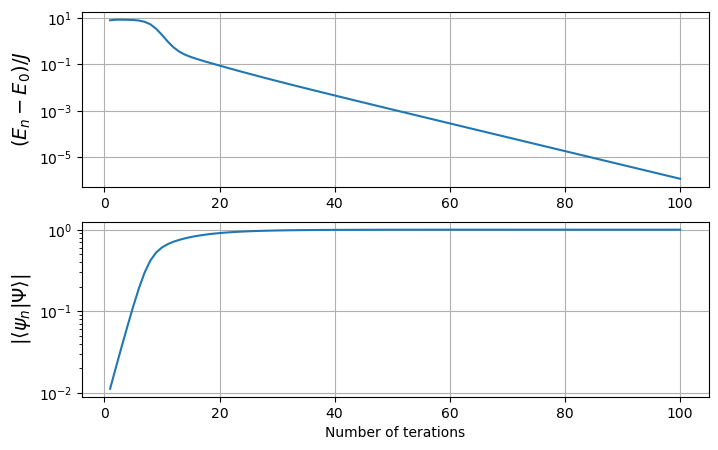

PyObject Text(0.5, 24.0, 'Number of terations')

In [172]:
ϕ = (1+sqrt(5))/2
fig,ax = subplots(2,1,figsize=(5*ϕ,5))
ax[1].plot(1:1:iterations,E .- E0)
ax[1].set_ylabel(L"$(E_{n}-E_0)/J$",fontsize=14);
ax[1].set_yscale("log")
ax[1].grid()
ax[2].plot(1:1:iterations,overlap)
ax[2].grid()
ax[2].set_yscale("log")
ax[2].set_ylabel(L"$|\langle\psi_n|\Psi\rangle|$",fontsize=14)
ax[2].set_xlabel("Number of terations")

## 01

Generalize the Hamiltonian for the Heisenberg model constructed in the tutorial to allow for a finite $J_2$ term. (Work in fixed $S_z$ sectors.) Try to think of different limits in which it is easy to check the ground state energy you obtain (e.g. for $J_1 = 0$ and $J_2 > 0$ the chain decouples into two independent chains with nearest neighbor coupling only).

**Answer:** Possible sanity checks are in at $g=0$ and $g^{-1}=0$.

When answering the questions below consider the following points in the phase diagram: $g = 0, g_c, 1/2$ and another value of $g$ of your choice that lies in the dimerized phase but away from $1/2$ (e.g. $g = 0.48$).

In [193]:
function ConstructJ1J2Hamiltonian(basis::FixedSzBasis, g::Float64)
    
    D = length(basis)
    
    H = spzeros(D,D)
    
    # Iterate over all the states in the basis |a> and calculate the nonzero matrix elements <b|H|a>
    # Recall that H = \sum_i H_{i,i+1}
    for k in range(1, length = D)
        a = basis.states[k]
        H[k,k] += basis.N
        for i in range(1, length = basis.N)
            j = mod1(i+1,basis.N) #PBC
            jj = mod1(i+2,basis.N) #PBC
            si = ( a & 1<<(i-1) ) >> (i-1)
            sj = ( a & 1<<(j-1) ) >> (j-1)
            sjj = ( a & 1<<(jj-1) ) >> (jj-1)

            if si == sj
                H[k,k] += 1/4
            else
                H[k,k] += - 1/4
                b = FlipSpins(a,i,j)
                l = searchsortedfirst(basis.states,b)
                @assert (l<=D) && (basis.states[l] == b) "Invalid basis state generated by FlipSpins"
                H[k,l] = 1/2
            end

            if si == sjj
                H[k,k] += 1/4*g
            else
                H[k,k] += - 1/4*g
                b = FlipSpins(a,i,jj)
                l = searchsortedfirst(basis.states,b)
                @assert (l<=D) && (basis.states[l] == b) "Invalid basis state generated by FlipSpins"
                H[k,l] = 1/2*g
            end
        end
    end
    
    return H
end

ConstructJ1J2Hamiltonian (generic function with 1 method)

# 02

Perform  finite-size scaling of the triplet gap (i.e. the energy gap between the ground state in the $S_z = 0$ sector to the lowest state in the $S_z = 1$ sector). Use even system sizes of up to (at least) $N = 22$ sites. To see the behavior of the gap in the thermodynamic limit, $N \rightarrow\infty$, more clearly, lot it as function of $1/N$ (and set the $x$ and $y$ axes to start at $0$). Check that the system is gapless for $g = 0,\;g_c$ (i.e. use a linear fit and check that the intersection in the $1/N\rightarrow\infty$ limit is consistent with zero), and that the gap is indeed finite for $g > g_c$ (i.e. use a quadratic fit and extract the value of the gap). Recall that the gap in the dimerized phase corresponds to breaking a singlet bond and creating two free spin ups (a.k.a. spinons).

In [226]:
Ns = 8:2:16
gs = [0, 0.241, 0.48, 0.5]

DeltaE = []
for g in gs
    E0 = []
    E1 = []
    for N in Ns

        Sz0basis=FixedSzBasis(N,div(N,2))
        H = ConstructJ1J2Hamiltonian(Sz0basis, g)
        append!(E0, sort(eigs(H; nev=10, ritzvec=false)[1])[1])

        Sz1basis=FixedSzBasis(N,div(N,2)+1)
        H = ConstructJ1J2Hamiltonian(Sz1basis, g)
        append!(E1, sort(eigs(H; nev=10, ritzvec=false)[1])[1])
    end
    append!(DeltaE, [E1-E0])
end

Dimension of subspace with S^z=0.0 is 70
Dimension of subspace with S^z=1.0 is 56
Dimension of subspace with S^z=0.0 is 252
Dimension of subspace with S^z=1.0 is 210
Dimension of subspace with S^z=0.0 is 924
Dimension of subspace with S^z=1.0 is 792
Dimension of subspace with S^z=0.0 is 3432
Dimension of subspace with S^z=1.0 is 3003
Dimension of subspace with S^z=0.0 is 12870
Dimension of subspace with S^z=1.0 is 11440
Dimension of subspace with S^z=0.0 is 70
Dimension of subspace with S^z=1.0 is 56
Dimension of subspace with S^z=0.0 is 252
Dimension of subspace with S^z=1.0 is 210
Dimension of subspace with S^z=0.0 is 924
Dimension of subspace with S^z=1.0 is 792
Dimension of subspace with S^z=0.0 is 3432
Dimension of subspace with S^z=1.0 is 3003
Dimension of subspace with S^z=0.0 is 12870
Dimension of subspace with S^z=1.0 is 11440
Dimension of subspace with S^z=0.0 is 70
Dimension of subspace with S^z=1.0 is 56
Dimension of subspace with S^z=0.0 is 252
Dimension of subspace with S

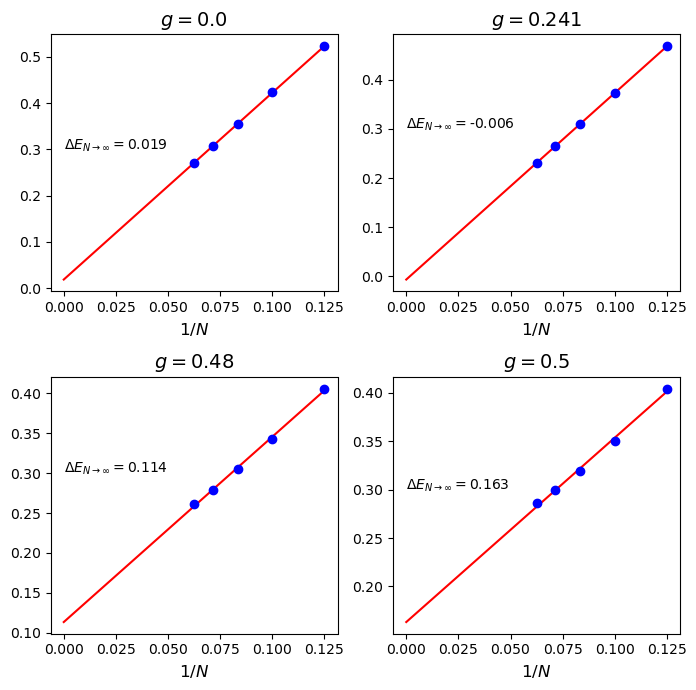

In [234]:
fig,ax = subplots(2,2,figsize=(7,7))
indx = [[1,1],[1,2],[2,1],[2,2]]
ys = [0.4, 0.35, 8,0]
x = LinRange(0,1/Ns[1],100)
for i = 1:4
    ax[indx[i][1],indx[i][2]].scatter(1 ./ Ns,DeltaE[i], color="blue",zorder=2)
    fit = curve_fit(f, 1 ./ Ns,DeltaE[i], [0.1,0.1])
    ax[indx[i][1],indx[i][2]].plot(x,f(x,fit.param),color="red",zorder=1)
    ax[indx[i][1],indx[i][2]].set_xlabel(L"$\Delta E$", fontsize=12)
    ax[indx[i][1],indx[i][2]].set_xlabel(L"$1/N$", fontsize=12)
    ax[indx[i][1],indx[i][2]].set_title(L"$g=$"*string(gs[i]), fontsize=14)
    textstr=L"$\Delta E_{N\rightarrow\infty}=$"*string(round(fit.param[2],digits=3))
    ax[indx[i][1],indx[i][2]].text(0.0, 0.3, textstr)
end
tight_layout()

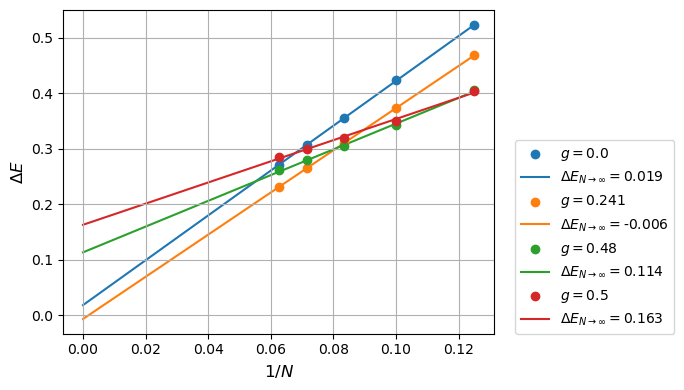

In [236]:
fig,ax = subplots(figsize=(7,4))

x = LinRange(0,1/Ns[1],100)
for i = 1:4
    ax.scatter(1 ./ Ns,DeltaE[i],zorder=2,label=L"$g=$"*string(gs[i]))
    fit = curve_fit(f, 1 ./ Ns,DeltaE[i], [0.1,0.1])
    ax.plot(x,f(x,fit.param),zorder=1,label=L"$\Delta E_{N\rightarrow\infty}=$"*string(round(fit.param[2],digits=3)))
end
ax.set_ylabel(L"$\Delta E$", fontsize=12)
ax.set_xlabel(L"$1/N$", fontsize=12)
ax.legend(loc=(1.05,0))
ax.grid()
tight_layout()

## 03

Perform finite-size scaling of the singlet gap (i.e. the energy gap to the first excited state in the $S_z = 0$ sector). Check that the gap decays exponentially for $g > g_c$ (e.g. plot the gap on a semi-log scale and check that the trend is linear). This is the gap between the states $|\psi_{1,2}\rangle=(|\psi_+\rangle\pm|\psi_-\rangle)/\sqrt{2}$ mentioned above. Note that for $g = 1/2$ the gap is expected to be zero identically for any system size.

In [242]:
Ns = 8:2:16
gs = [0, 0.241, 0.48, 0.5]

DeltaE = []
for g in gs
    dE = []
    for N in Ns

        Sz0basis=FixedSzBasis(N,div(N,2))
        H = ConstructJ1J2Hamiltonian(Sz0basis, g)
        E = sort(eigs(H; nev=10, ritzvec=false)[1])
        append!(dE, E[2]-E[1] < 1e-13 ? 0 : E[2]-E[1])
            
    end
    append!(DeltaE, [dE])
end

Dimension of subspace with S^z=0.0 is 70
Dimension of subspace with S^z=0.0 is 252
Dimension of subspace with S^z=0.0 is 924
Dimension of subspace with S^z=0.0 is 3432
Dimension of subspace with S^z=0.0 is 12870
Dimension of subspace with S^z=0.0 is 70
Dimension of subspace with S^z=0.0 is 252
Dimension of subspace with S^z=0.0 is 924
Dimension of subspace with S^z=0.0 is 3432
Dimension of subspace with S^z=0.0 is 12870
Dimension of subspace with S^z=0.0 is 70
Dimension of subspace with S^z=0.0 is 252
Dimension of subspace with S^z=0.0 is 924
Dimension of subspace with S^z=0.0 is 3432
Dimension of subspace with S^z=0.0 is 12870
Dimension of subspace with S^z=0.0 is 70
Dimension of subspace with S^z=0.0 is 252
Dimension of subspace with S^z=0.0 is 924
Dimension of subspace with S^z=0.0 is 3432
Dimension of subspace with S^z=0.0 is 12870


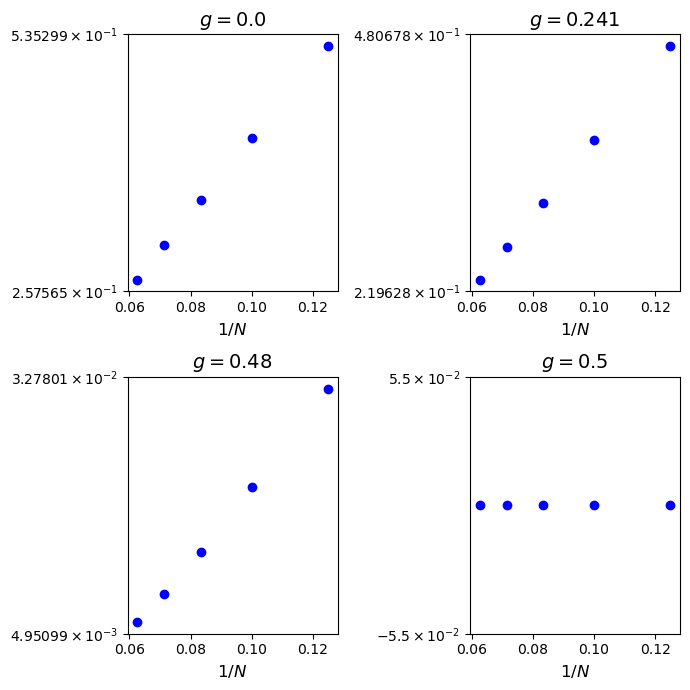

In [243]:
fig,ax = subplots(2,2,figsize=(7,7))
indx = [[1,1],[1,2],[2,1],[2,2]]
ys = [0.4, 0.35, 8,0]
x = LinRange(0,1/Ns[1],100)
for i = 1:4
    ax[indx[i][1],indx[i][2]].scatter(1 ./ Ns,DeltaE[i], color="blue",zorder=2)
    # fit = curve_fit(f, 1 ./ Ns,DeltaE[i], [0.1,0.1])
    # ax[indx[i][1],indx[i][2]].plot(x,f(x,fit.param),color="red",zorder=1)
    ax[indx[i][1],indx[i][2]].set_xlabel(L"$\Delta E$", fontsize=12)
    ax[indx[i][1],indx[i][2]].set_xlabel(L"$1/N$", fontsize=12)
    ax[indx[i][1],indx[i][2]].set_title(L"$g=$"*string(gs[i]), fontsize=14)
    # textstr=L"$\Delta E_{N\rightarrow\infty}=$"*string(round(fit.param[2],digits=3))
    # ax[indx[i][1],indx[i][2]].text(0.0, ys[i], textstr)
    ax[indx[i][1],indx[i][2]].set_yscale("symlog")
end
tight_layout()

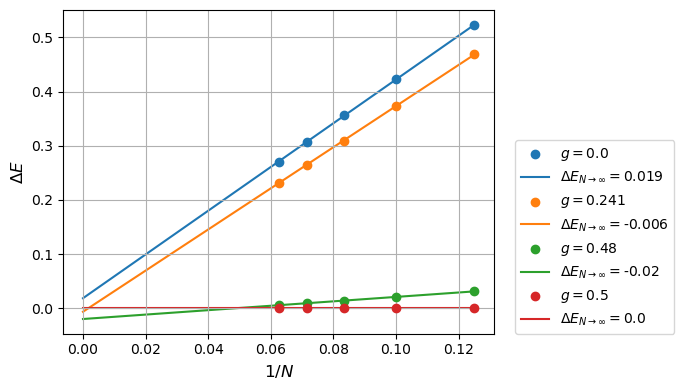

In [244]:
fig,ax = subplots(figsize=(7,4))

x = LinRange(0,1/Ns[1],100)
for i = 1:4
    ax.scatter(1 ./ Ns,DeltaE[i],zorder=2,label=L"$g=$"*string(gs[i]))
    fit = curve_fit(f, 1 ./ Ns,DeltaE[i], [0.1,0.1])
    ax.plot(x,f(x,fit.param),zorder=1,label=L"$\Delta E_{N\rightarrow\infty}=$"*string(round(fit.param[2],digits=3)))
end
ax.set_ylabel(L"$\Delta E$", fontsize=12)
ax.set_xlabel(L"$1/N$", fontsize=12)
ax.legend(loc=(1.05,0))
ax.grid()
tight_layout()

## 04

Calculate the spin-spin correlations in the ground state of the system, i.e. the expectation value of $\langle \vec{S}_1\cdot\vec{S}_{1+x}\rangle$ as function of $x$. To this end, use only the largest system size you considered above. Note that due to spin-rotation symmetry it is enough to calculate $\langle S_1^z S_{1+x}^z\rangle$ since  $\langle S_1^z S_{1+x}^z\rangle=\frac{1}{3}\langle \vec{S}_1\cdot\vec{S}_{1+x}\rangle$. Show that for $g\leq g_c$ these correlations decay as a power law (up to logarithmic corrections that we won't discuss here), while for $g>g_c$ the decay is exponential. Note that this might be hard to observe close to the critical point (since at that point the correlation length diverges), but should be clearly visible for $g$ close to $1/2$. Tips: to see a power law decay use a log-log plot and to see an exponential decay use a semi-log plot. You can change the scale of the axis in Julia (similarly to Python) by `xscale("log")` or `yscale("log")` respectively.


To observe dimerization, bond-bond correlations are typically considered. These are defined as $\langle B_1 B_{1+x}\rangle$, where $B_i = \vec{S}_i\cdot\vec{S}_{1+i}$ (i.e. $B_i$ is the "strength" of the bond between sites $i$ and $i + 1$). Here, for simplicity, we will consider $\langle B_1^z B^z_{1+x}\rangle$ where $B_i^z=S_i^zS^z_{i+1}$. (Note that unlike in the case of spin-spin correlations these are not related to each other in a simple way, but it will be enough to consider the latter correlations to see the ordering.)

In [295]:
function Corr(basis::FixedSzBasis,psi::Vector)
    dim = length(basis)
    L   = basis.N 
    spins = zeros(L,dim)

    for k =1:dim
        a = basis.states[k]
        
        i0 = div(L,2)
        si0 = ( a & 1<<(i0-1) ) >> (i0-1)
        
        for i = 1:L
            si = ( a & 1<<(i-1) ) >> (i-1)
            spins[i,k] = (si0 == si ? 1/4 : -1/4)
        end
    end
    return spins*abs.(psi).^2
end

Corr (generic function with 2 methods)

In [312]:
N = 20

corr = []
Sz0basis=FixedSzBasis(N,div(N,2))
for g in gs
    H = ConstructJ1J2Hamiltonian(Sz0basis, g)
    E,psi = eigs(H; nev=2, ritzvec=true)
    append!(corr,[Corr(Sz0basis,psi[:,1])])
end

Dimension of subspace with S^z=0.0 is 184756


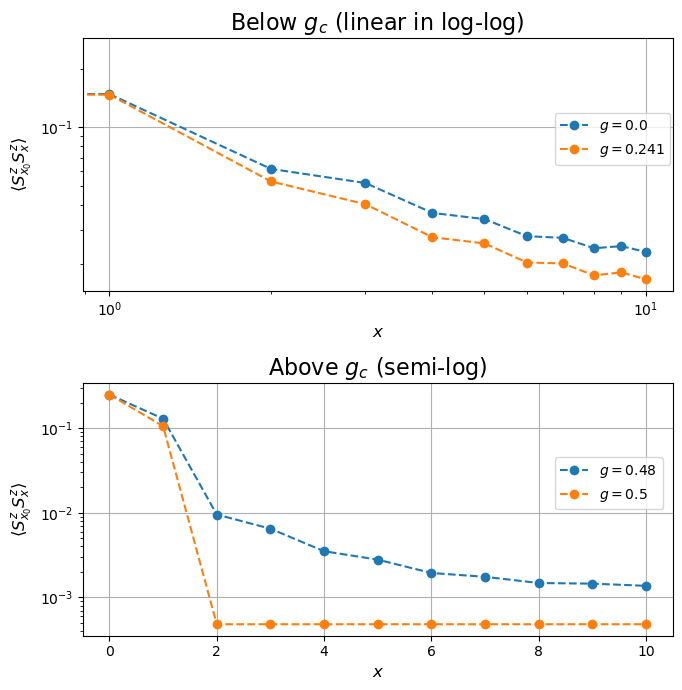

In [337]:
fig,ax = subplots(2,1,figsize=(7,7))

x = LinRange(0,1/Ns[1],100)
titles=[L"Below $g_c$ (linear in log-log)",L"Above $g_c$ (semi-log)"]
for i = 1:2
    ax[1].plot(abs.(corr[i][10:20]),"--o",zorder=2,label=L"$g=$"*string(gs[i]))
    ax[2].plot(abs.(corr[i+2][10:20]),"--o",zorder=2,label=L"$g=$"*string(gs[i+2]))
end
for i = 1:2
    ax[i].set_ylabel(L"$\langle S^z_{x_0} S^z_x \rangle$", fontsize=12)
    ax[i].set_xlabel(L"$x$", fontsize=12)
    ax[i].legend(loc=(0.8,0.5))
    ax[i].set_yscale("log")
    ax[i].grid()
    ax[i].set_title(titles[i], fontsize=16)
end
ax[1].set_xscale("log")
tight_layout()

## 05

Calculate $\langle B_1^z B_{1+x}^z\rangle -\langle B_1^z \rangle\langle B_{1+x}^z\rangle$ as function of $x$ in the ground state of the system. (Again, use the largest system size you considered above.) What is the behavior of this order parameter for $g\leq g_c$? Show that for $g>g_c$ this order parameter saturates to a finite value (up to the alternating sign). Once again, this might be difficult to see close to $g_c$ but should be clearly visible close to $g = 1/2$.

**Solution:**
All we need to do is to calculate the 4-point correlation.

In [400]:
function ExpvalBond(basis::FixedSzBasis,psi::Vector)
    dim = length(basis)
    B = zeros(basis.N, dim)

    for k = 1:dim
        a = basis.states[k]

        for i = 1:basis.N
            j = mod1(i+1,basis.N)
            si = ( a & 1<<(i-1) ) >> (i-1)
            sj = ( a & 1<<(j-1) ) >> (j-1)
            B[i,k] = si == sj ? 1/4 : -1/4
        end
    end
    
    bs = []


    for i = 1:basis.N
        append!(bs,dot(B[i,:],abs.(psi).^2))
    end
    return bs
end

function BondCorr(basis::FixedSzBasis,psi::Vector)
    dim = length(basis)
    BB = zeros(basis.N, dim)

    for k = 1:dim
        a = basis.states[k]

        s1 = ( a & 1<<(1-1) ) >> (1-1)
        s2 = ( a & 1<<(2-1) ) >> (2-1)

        for i = 1:basis.N
            j = mod1(i+1,basis.N)
            si = ( a & 1<<(i-1) ) >> (i-1)
            sj = ( a & 1<<(j-1) ) >> (j-1)
            BB[i,k] = (s1-1/2)*(s2-1/2)*(si-1/2)*(sj-1/2)
        end
    end
    
    bbs = []


    for i = 1:basis.N
        append!(bbs,dot(BB[i,:],abs.(psi).^2))
    end
    return bbs
end

BondCorr (generic function with 1 method)

In [506]:
N = 16

res = []
basis0 = FixedSzBasis(N,div(N,2))
for g in gs
    H = ConstructJ1J2Hamiltonian(basis0, g)
    E0,psi0 = eigs(H; which=:SR ,nev=4, ritzvec=true)
    BB = BondCorr(basis0,psi0[:,1])
    B  = ExpvalBond(basis0,psi0[:,1])
    # print(B)
    append!(res,[BB .- B[1] .* B  ])
end

Dimension of subspace with S^z=0.0 is 12870


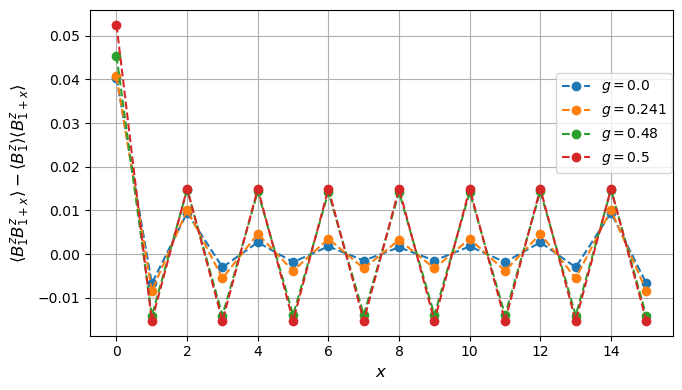

In [507]:
fig,ax = subplots(figsize=(7,4))

for i = 1:4
    ax.plot(res[i][:],"--o",zorder=2,label=L"$g=$"*string(gs[i]))
end

ax.set_ylabel(L"$\langle B^z_{1} B^z_{1+x} \rangle-\langle B^z_1\rangle\langle B^z_{1+x}\rangle$", fontsize=12)
ax.set_xlabel(L"$x$", fontsize=12)
ax.legend(loc=(0.8,0.5))
ax.grid()
tight_layout()

Let us define the minimal value for each $g$ with a given system size $N$. To be noticed, $g=0.5$ the GS is 2-fold degenerated, thus the eigenvector we get for the Lanczos is a superposition of them and makes the calculation messy. $g=0.48$ is close enough to see the finite parameter when scaling.

In [527]:
Ns = 8:2:18
res = zeros(length(Ns),length(gs))
for (i,N) in enumerate(Ns)
    basis0 = FixedSzBasis(N,div(N,2))
    for (ii,g) in enumerate(gs[1:3])
        H = ConstructJ1J2Hamiltonian(basis0, g)
        E0,psi0 = eigs(H; nev=4, ritzvec=true)
        
        BB = BondCorr(basis0,psi0[:,1])
        B  = ExpvalBond(basis0,psi0[:,1])
        res[i,ii] = minimum(abs.(BB .- B[1] .* B ))
    end
end

Dimension of subspace with S^z=0.0 is 70
Dimension of subspace with S^z=0.0 is 252
Dimension of subspace with S^z=0.0 is 924
Dimension of subspace with S^z=0.0 is 3432
Dimension of subspace with S^z=0.0 is 12870
Dimension of subspace with S^z=0.0 is 48620


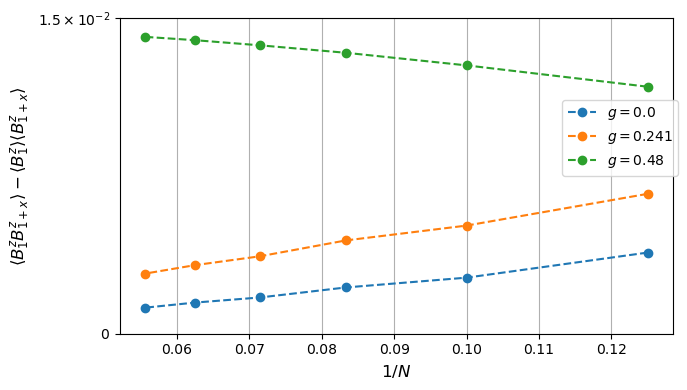

In [529]:
fig,ax = subplots(figsize=(7,4))

for i = 1:3
    ax.plot(1 ./Ns,res[:,i],"--o",zorder=2,label=L"$g=$"*string(gs[i]))
end

ax.set_ylabel(L"$\langle B^z_{1} B^z_{1+x} \rangle-\langle B^z_1\rangle\langle B^z_{1+x}\rangle$", fontsize=12)
ax.set_xlabel(L"$1/N$", fontsize=12)
ax.legend(loc=(0.8,0.5))
ax.set_yscale("symlog")
ax.set_ylim([0,0.015])
ax.grid()
tight_layout()